<a href="https://colab.research.google.com/github/kavyajeetbora/modern_geospatial_stack/blob/master/notebooks/02_download_metro_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TODO:

1. Evaluate the downloaded data from https://themetrorailguy.com/
2. Once evaluated, export it to parquet format

## Install Dependencies and Import Modules

In [1]:
!pip install -q osmnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.2/107.2 kB 2.4 MB/s eta 0:00:00


In [2]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
from tqdm import tqdm

## Download OSM Data

In [4]:
## Note: the coordinates are in West, South, East, North format

bboxs = {
    'Mumbai': (72.7712628039,18.8895552464,73.0912396106,19.322318006),
    'Hyderabad': (78.2288393192,17.1952635128,78.692325037,17.6244114807),
    'Bangalore': (77.4480254838,12.815481916,77.7549560258,13.1026335949),
    'Chennai': (80.0337033915,12.8678089117,80.335827415,13.2370438819),
    'Kolkata': (88.2431406976,22.4883995072,88.4944529534,22.7071046611),
    'Ahmedabad': (72.4617185823,22.9179551449,72.699297928,23.1470216925),
    'Delhi_NCR': (76.881197,28.31444,77.604922,28.893765)
}

columns = ['element_type', 'osmid', 'geometry', 'railway', 'internet_access',
       'name', 'name:hi', 'network', 'operator', 'public_transport',
       'ref', 'train','city']

In [7]:

%%time
W,S,E,N = bboxs['Ahmedabad']
public_transport = ox.features.features_from_bbox(bbox=(N,S,E,W), tags={'railway':True}).reset_index()
public_transport.head()

CPU times: user 411 ms, sys: 2.58 ms, total: 414 ms
Wall time: 415 ms


,element_type,osmid,railway,geometry,passenger_lines,internet_access,name,network,operator,public_transport,...,building,operator:wikidata,operator:wikipedia,information,tourism,wheelchair,opening_date,network:wikidata,air_conditioning,ele
0,node,322770837,level_crossing,POINT (72.60274 23.03853),1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node,322770856,station,POINT (72.65809 23.08541),NaN,no,Naroda,IR,WR,station,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,node,322866991,level_crossing,POINT (72.65445 22.91810),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,node,322867002,level_crossing,POINT (72.63159 22.95405),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,node,322983248,level_crossing,POINT (72.56178 23.05775),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
public_transport.shape

(668, 73)

In [9]:
public_transport['railway'].value_counts()

railway
rail                 256
level_crossing       114
subway                94
stop                  81
station               45
buffer_stop           21
platform              21
construction          12
switch                 6
crossing               4
technical_station      4
abandoned              3
proposed               2
subway_entrance        1
vacancy_detection      1
halt                   1
depot                  1
yard                   1
Name: count, dtype: int64

<Axes: >

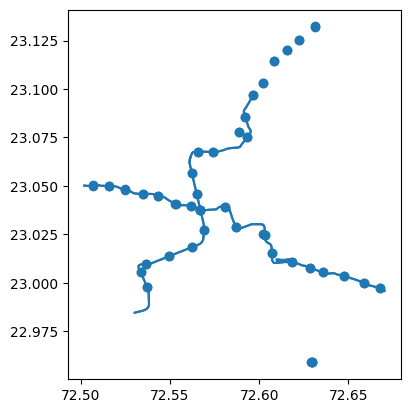

In [20]:
ax= public_transport[public_transport['railway']=='subway'].plot()
public_transport[public_transport['railway']=='stop'].plot(ax=ax)

<Axes: >

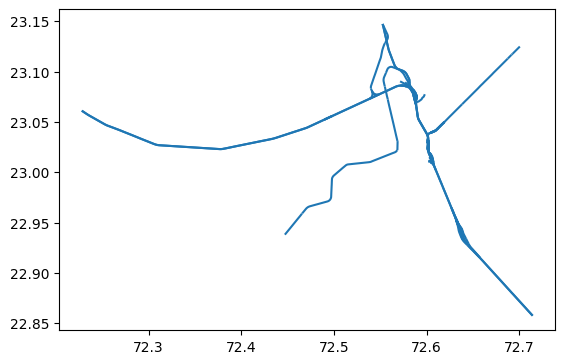

In [13]:
public_transport[public_transport['railway']=='rail'].plot()

In [ ]:
%%time
# city = 'Dehli_NCR'
metro_stops = []
metro_lines = []

for city, bbox in tqdm(bboxs.items(), unit=' cities'):

    ## Download OSM data
    W,S,E,N = bboxs[city]
    public_transport = ox.features.features_from_bbox(bbox=(N,S,E,W), tags={'railway':True}).reset_index()
    public_transport['city'] = city
    # print("Length of the dataframe" , public_transport.shape[0])

    ## Extract Metro Stops
    stops = public_transport.loc[(public_transport['element_type']=='node') & (public_transport['railway']=='station')].copy()
    stops['city'] = city
    # print(f"Number of stations: {stops.shape[0]} in {city}")

    ## Extract Metro Lines
    lines = public_transport.loc[
        (public_transport['element_type']=='way') &
         (public_transport['railway'].notna())
    ].copy()

    lines['geometry'] = lines['geometry'].clip_by_rect(W,S,E,N)
    # print(f"Number of lines: {lines.shape[0]} in {city}")

    metro_lines.append(lines)
    metro_stops.append(stops)

metro_line_df = pd.concat(metro_lines)[columns]
metro_station_df = pd.concat(metro_stops)[columns]

print("Total number of metro lines: ", metro_line_df.shape[0])
print("Total number of metro stations: ", metro_station_df.shape[0])

100%|██████████| 7/7 [00:07<00:00,  1.10s/ cities]


Total number of metro lines:  11638
Total number of metro stations:  846
CPU times: user 8.67 s, sys: 94.5 ms, total: 8.77 s
Wall time: 9.16 s


## Evaluate the data

Evaluate the data by visualizing and inspecting the dataframes for each city

In [ ]:
metro_line_df[columns].sample(5)

,element_type,osmid,geometry,railway,internet_access,name,name:hi,network,operator,public_transport,ref,train,city
548,way,847089580,"LINESTRING (72.60979 23.01094, 72.61122 23.01093)",subway,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ahmedabad
1044,way,356964961,"LINESTRING (78.51752 17.49836, 78.51770 17.497...",rail,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hyderabad
6185,way,439020815,"LINESTRING (77.30284 28.54200, 77.30343 28.542...",subway,NaN,Delhi Metro Magenta Line,NaN,Delhi Metro,Delhi Metro Rail Corporation Limited,NaN,NaN,NaN,Delhi_NCR
4489,way,807900861,"LINESTRING (73.01562 19.20579, 73.01534 19.205...",rail,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mumbai
1493,way,141182198,"LINESTRING (77.65239 12.99067, 77.65305 12.990...",subway,NaN,Namma Metro - Reach 1,NaN,Namma Metro,Bangalore Metro Rail Corporation Limited,NaN,NaN,NaN,Bangalore


## Visualize the Downloaded data

Visualize all the metro lines for a city

Number of lines: 39


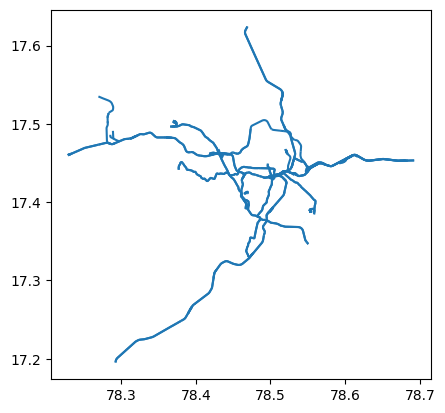

In [ ]:
city = "Hyderabad"
city_df = metro_line_df[metro_line_df['city']==city]
metro_lines = city_df.loc[(public_transport['railway']=='subway')]
print(f"Number of lines: {metro_lines.shape[0]}")
city_df.plot();

Number of stations: 18


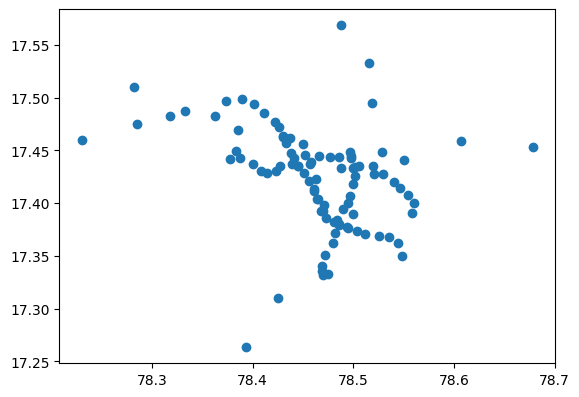

In [ ]:
city_stn_df = metro_station_df[metro_station_df['city']==city]
metro_stns = city_stn_df.loc[(public_transport['railway']=='subway')]
print(f"Number of stations: {metro_stns.shape[0]}")
city_stn_df.plot();

## Export to Parquet files

Once the evaluation of the data is done, export it to parquet format file

In [ ]:
metro_station_df.to_parquet('stations.parquet')
metro_line_df[columns].to_parquet('lines.parquet')